In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [36]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [37]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [38]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [39]:
# View all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [40]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [42]:
# Create our session (link) from Python to the DB
session = Session(engine)



# Exploratory Precipitation Analysis

In [154]:
# Find the most recent date in the data set.
# 
# Query the date column of the Measurement table, then order by date descending, then limit the 
# output to one record:
dates = session.query(Measurement, Measurement.date).order_by(Measurement.date.desc()).limit(1).all()

# Returns a list with a tuple in it, containing the object and the date:
# [(<sqlalchemy.ext.automap.measurement object at 0x7fe5490bf0a0>, '2017-08-23')]
# print(dates)

# Returns a tuple with an object and the date:
# (<sqlalchemy.ext.automap.measurement object at 0x7fe5490bf0a0>, '2017-08-23')
# print(dates[0])

# Returns just the date
# 2017-08-23
date = dates[0][1]
print(date)

# Could have also done this by using 'scalar' instead fo 'all':
# date = session.query(Measurement.date).order_by(Measurement.date.desc()).limit(1).scalar()
# print(date)

2017-08-23


In [155]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# 
# This approach uses date passed as a string from above.  However, the rubric says not to do that, 
# so it's reimplemented as a sql query in the cell below.  Keeping this as reference ... 
# 
'''
# Convert the date into year, month, and day, while also stripping leading zeros from month and day:
date_list = date.split("-")
# date_list
year=date_list[0]
month=date_list[1].lstrip('0')
day=date_list[2].lstrip('0')
# print(year)
# print(month)
# print(day)

# Calculate the date one year from the last date in data set.
# 
# Convert year, month and day to integers for dt.time and take the delta:
year_ago = dt.date(int(year), int(month), int(day)) - dt.timedelta(days=365)
# print(year_ago)

# Perform a query to retrieve the data and precipitation scores
precip = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > year_ago).\
    order_by(Measurement.date).all()
'''

'\n# Convert the date into year, month, and day, while also stripping leading zeros from month and day:\ndate_list = date.split("-")\n# date_list\nyear=date_list[0]\nmonth=date_list[1].lstrip(\'0\')\nday=date_list[2].lstrip(\'0\')\n# print(year)\n# print(month)\n# print(day)\n\n# Calculate the date one year from the last date in data set.\n# \n# Convert year, month and day to integers for dt.time and take the delta:\nyear_ago = dt.date(int(year), int(month), int(day)) - dt.timedelta(days=365)\n# print(year_ago)\n\n# Perform a query to retrieve the data and precipitation scores\nprecip = session.query(Measurement.date, Measurement.prcp).    filter(Measurement.date > year_ago).    order_by(Measurement.date).all()\n'

In [156]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# 
# Alternate way to do the query that doesn't require one to pass in the date string.  
# However, `subquery` is also a variable and some may consider that to be passing the 
# date in as a variable, so it's reimplemented below without use of any variable.  
# 
'''
subquery = session.query(func.date(func.datetime(Measurement.date, '-365 days')))\
    .order_by(Measurement.date.desc()).limit(1).scalar()
precip = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > (subquery))\
        .order_by(Measurement.date).all()
'''

"\nsubquery = session.query(func.date(func.datetime(Measurement.date, '-365 days')))    .order_by(Measurement.date.desc()).limit(1).scalar()\nprecip = session.query(Measurement.date, Measurement.prcp).    filter(Measurement.date > (subquery))        .order_by(Measurement.date).all()\n"

In [157]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# 
# This query uses a subquery to get the most recent date in the table and subtract 365 days 
# from that date.  Then it uses a filter to return all rows more recent than that date.  
# 
# Returns a list of tuples, like this:
# [('2016-08-24', 0.08), ('2016-08-24', 2.15), ('2016-08-24', 2.28), ('2016-08-24', None), ...
precip = session.query(Measurement.date, Measurement.prcp).\
    filter(
        Measurement.date > (
            session.query(func.date(func.datetime(Measurement.date, '-365 days')))\
            .order_by(Measurement.date.desc()).limit(1).scalar()
        ) 
    )\
    .order_by(Measurement.date).all()
# print(precip)

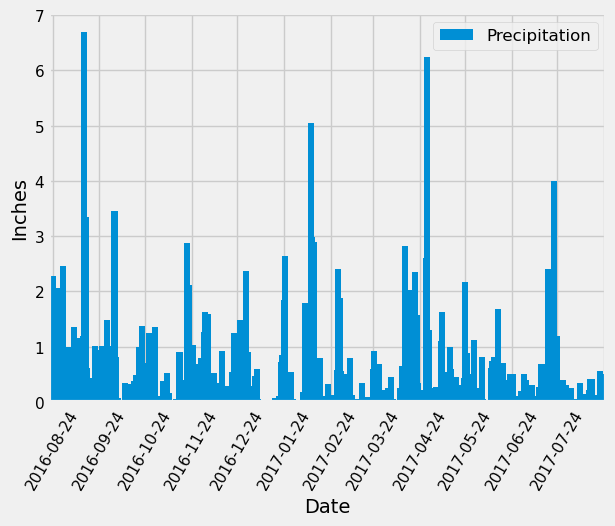

In [158]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(precip, columns = ['Date', 'Precipitation']).set_index('Date')
precip_df

# Sort the dataframe by date
precip_df = precip_df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
plot_df = precip_df.groupby('Date').max()
plot_df

# plot_df.plot().bar(x='Precipitation', y='Date') 
plot_df.plot(kind="bar", width=4, fontsize=11)
plt.ylabel("Inches", fontsize=14)
plt.xlabel("Date", fontsize=14)
plt.xticks([0,31,61,92,122,153,184,212,243,273,304,334,365],rotation=60)
plt.legend(loc='upper right', prop={'size': 12})
plt.show()

In [159]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

Precipitation
count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000

# Exploratory Station Analysis

In [ ]:
# Design a query to calculate the total number stations in the dataset


In [ ]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.


In [ ]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.


In [ ]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


# Close session

In [ ]:
# Close Session
session.close()